<div>
<center><img src="img/logistigate_logo2.png" alt="Drawing" width="700"></center>
</div>

## Overview of `logistigate`
The `logistigate` methods infer rates of substandard and falsified products (SFPs) at locations within a two-echelon supply chain, using testing data only from samples of products at locations of the lower echelon.

Each location of both echelons has some fixed SFP rate.
Non-SFP products traveling through a location become SFP according to this rate.
Upper-echelon locations are called *supply nodes*, and lower-echelon locations are called *test nodes*.
The decision for designating an upstream supply-chain echelon as the set of supply nodes is left with the modeler.
Test nodes are consumer facing ends of the supply chain.
All products travel through one supply node and one test node.
The probabilities with which test nodes obtain products from supply nodes are stored in a "sourcing-probability matrix."
Product testing at test nodes is conducted with a diagnostic tool with a known sensitivity and specificity.
Detection of an SFP is recorded as "1" and no detection is recorded as "0."
There are two types of supply-chain information available to regulators, Tracked and Untracked:
 - In the *Tracked* case, both the supply node and test node traversed by each tested product are known upon testing.
 - In the *Untracked* case, only the test node is known, in addition to the sourcing-probability matrix.

See the paper [on Arxiv](https://arxiv.org/abs/2207.05671) for a full description of the `logistigate` methods.

## Installation
Before using `logistigate`, you need to ensure it is installed in your Python library. To do this, open a Command console, and run the following line, using `pip`:

`pip install git+https://github.com/eugenewickett/logistigate.git#egg=logistigate`

OR 

`pip install logistigate`

([See here](https://pip.pypa.io/en/stable/installing/) for help installing `pip` if you do not already have it.)

## Example
This example illustrates `logistigate`'s capabilities with a small supply chain.
This supply chain consists of three supply nodes, called "Importers" for this example, and twelve test nodes, called "Outlets."
Outlets procure products from importers according to a (possibly known or unknown) *sourcing-probability matrix*; consumers obtain products directly at test nodes.
The sourcing-probability matrix for this example is shown here, in percentages:

| . | Importer 1 | Importer 2 | Importer 3 |
| --- | --- | --- | --- |
|Outlet 1| 69 | 22 | 9 |
|Outlet 2| 13 | 32 | 55 |
|Outlet 3| 39 | 51 | 10 |
|Outlet 4| 1 | 92 | 7 |
|Outlet 5| 28 | 22 | 50 |
|Outlet 6| 84 | 4 | 12 |
|Outlet 7| 11 | 60 | 29 |
|Outlet 8| 43 | 25 | 32 |
|Outlet 9| 11 | 65 | 24 |
|Outlet 10| 60 | 05 | 35 |
|Outlet 11| 5 | 15 | 80 |
|Outlet 12| 40 | 15 | 45 |

For instance, a product procured from Outlet 6 has an $84\%$ chance of originating from Importer 1, a $4\%$ chance of originating from Importer 2, and a $12\%$ chance of originating from Importer 3.

In pharmaceutical post-market surveillance, regulators only test products at the consumer-facing end of the supply chain, i.e., from the outlets.
In this situation where testing only occurs at the outlet level, it is not apparent upon the detection of an SFP whether the ultimate source of the SFP was due to the importer or the outlet.
**The goal of `logistigate` is inference of the SFP rates at nodes in both supply-chain echelons, using testing data from the lower echelon and some degree of supply-chain information.**

For our example, suppose that importers and outlets generate SFPs as listed in the following tables (again, in percentages):

| Importer 1 | Importer 2 | Importer 3 |
| --- | --- | --- |
| 40 | 30 | 20 |



| Outlet 1 | Outlet 2 | Outlet 3 | Outlet 4 | Outlet 5 | Outlet 6 | Outlet 7 | Outlet 8 | Outlet 9 | Outlet 10 | Outlet 11 | Outlet 12 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 71 | 3 | 10 | 38 | 28 | 62 | 50 | 9 | 20 | 13 | 80 | 6 |



For example, a product procured from Outlet 3 that originated from Importer 2 has a $0.3 + (1-0.3)*0.1=0.37$ probability of being an SFP.

In the Tracked setting, each sample used for testing bears an Outlet label and an Importer label reflecting that sample's path through the supply chain.
In the Untracked setting, each sample bears an Outlet label only.
The known sourcing-probability matrix is the only supply-chain information that ties Outlets to Importers.
Note that knowledge of the sourcing-probability matrix is not necessary in the Tracked setting, but is required for the Untracked setting.

### Using `logistigate`: the Tracked setting
We first consider how we might use `logistigate` in the Tracked setting.
As described above, Tracked data consist of three different features for each tested sample: outlet, importer, and test result. The following displays the first ten rows of `example1TestData.csv` included in the `logistigate` package:

| Outlet Name | Importer Name | Test Result |
| --- | --- | --- |
| Outlet_03 | Importer_1 |	1 |
| Outlet_09 | Importer_2 |	0 |
| Outlet_12 | Importer_3 |	1 |
| Outlet_01 | Importer_3 |	1 |
| Outlet_05 | Importer_3 |	0 |
| Outlet_09 | Importer_2 |	1 |
| Outlet_01 | Importer_1 |	1 |
| Outlet_03 | Importer_1 |	0 |
| Outlet_09 | Importer_1 |	0 |
| Outlet_08 | Importer_1 |  1 |


In total, `example1TestData.csv` contains 4,000 test rows, generated for this example in the following manner:
 - Randomly (and uniformly) choose one of the twelve outlets; this is our "current" outlet.
 - Randomly choose one of the three importers, weighted by the sourcing-probability matrix at the row of the current outlet; this is our "current" importer.
 - Randomly generate a test result as a function of the SFP rates at the current outlet and importer, and the sensitivity and specificity of the diagnostic tool.

Given these testing data, `logistigate` provides inference of the SFP rates at each outlet and importer.

First, import necessary modules from `logistigate`, as well as the `pkg_resources` module which will allow us to use the CSV file that comes with `logistigate`.

In [1]:
from logistigate import utilities as util
from logistigate import methods, lg
import pkg_resources


Next, we provide the CSV file path to the `TestResultsFileToTable()` function, which takes a CSV file path as input and returns a data dictionary that can be used with other `logistigate` methods.

In [2]:
dataTblDict = util.TestResultsFileToTable('data/example1TestData.csv')

Let us look at the keys of this `dataTblDict` dictionary:

In [3]:
print(dataTblDict.keys())

dict_keys(['type', 'transMat', 'dataTbl', 'outletNames', 'importerNames', 'N', 'Y'])


`'type'` is either one of Tracked (if three input data columns) or Untracked (if only two input data columns: outlet name and testing result).
If providing Untracked data, then `'transMat'` is also required as an input to `TestResultsFileToTable()` (this will be an empty list for Tracked data). `'dataTbl'` is a Python-friendly list of the testing data CSV. `'outletNames'` and `'importerNames'` are sorted lists of the entered entity names. `'N'` and `'Y'` are matrix (Tracked) or vector (Untracked) summaries of the testing results of `'dataTbl'`, and constitute the principal objects of analysis within the `logistigate` methods. `'N'` contains the total number of tests conducted at each outlet-importer path (Tracked) or outlet (Untracked), while `'Y'` contains the number of positive tests at each outlet-importer path or outlet.

Once the testing data is in a format (`dataTblDict`) suitable for `logistigate`, we need to provide a few more pieces of information to the data dictionary in order to conduct inference.

In [4]:
dataTblDict.update({'diagSens':0.90, 'diagSpec':0.99, 'numPostSamples':1000, 'prior':methods.prior_normal()})

`'diagSens'` and `'diagSpec'` signify the sensitivity and specificity, respectively, of the diagnostic tool used to collect the testing data. For our example, these data were generated using a "device" with $90\%$ sensitivity and $99\%$ specificity.

`'numPostSamples'` refers to the desired number of posterior draws, using Markov Chain Monte Carlo sampling.
These draws are constructed using the testing data and beliefs on the distribution of SFP rates prior to testing.
Each draw is a possible underlying set of SFP rates that might have generated the observed testing data.
Taken as a set, these draws provide a picture of likely SFP rates for each outlet and importer.
The number of draws to generate is up to the user; more draws require more computing time but provide stronger inference precision.

`'prior'` signifies the prior distribution to use in forming the posterior.
It should capture the user's beliefs prior to collecting data regarding SFP-rate patterns across the supply chain.
`logistigate` includes Normal and Laplace distributions; see `methods` for more details regarding the setting prior distributions, or if you wish to construct your own priors.

Once the data dictionary contains these different elements, we can conduct inference using `runLogistigate()`, which returns an output dictionary.

In [6]:
logistigateDict = lg.runLogistigate(dataTblDict)

In [7]:
print(logistigateDict.keys())

dict_keys(['type', 'dataTbl', 'transMat', 'outletNames', 'importerNames', 'outletNum', 'importerNum', 'diagSens', 'diagSpec', 'N', 'Y', 'estDict', 'postSamples', 'prior'])


`runLogistigate()` maintains the keys of the input data dictionary, but adds `postSamples`: this key contains a list of posterior samples as described above. See the `methods` module for details on implementation.

`utilities` provides functionality for plotting the results from `runLogistigate()`: `printEstimates()` presents credible intervals in a table, while `plotPostSamples()` provides histograms of the posterior samples.

For ease of reference, recall the SFP rates we are attempting to infer, as presented at the beginning of this example:

| Importer 1 | Importer 2 | Importer 3 |
| --- | --- | --- |
| 40 | 30 | 20 |



| Outlet 1 | Outlet 2 | Outlet 3 | Outlet 4 | Outlet 5 | Outlet 6 | Outlet 7 | Outlet 8 | Outlet 9 | Outlet 10 | Outlet 11 | Outlet 12 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 71 | 3 | 10 | 38 | 28 | 62 | 50 | 9 | 20 | 13 | 80 | 6 |



************************************************************************************************************************
ESTIMATE DICTIONARY VALUES
************************************************************************************************************************
Importer Name    Max. Lklhd. Est.    99% Lower    95% Lower    90% Lower    90% Upper    95% Upper    99% Upper
---------------  ------------------  -----------  -----------  -----------  -----------  -----------  -----------
Importer_1       38.8%               33.5%        34.8%        35.4%        42.4%        43.1%        44.5%
Importer_2       26.1%               21.1%        22.2%        22.8%        29.7%        30.5%        31.9%
Importer_3       16.4%               12.1%        13.1%        13.5%        19.6%        20.3%        21.6%
************************************************************************************************************************
************************************************************

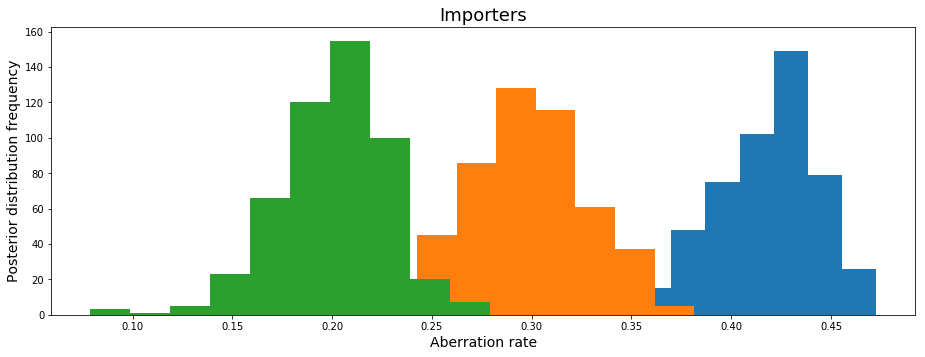

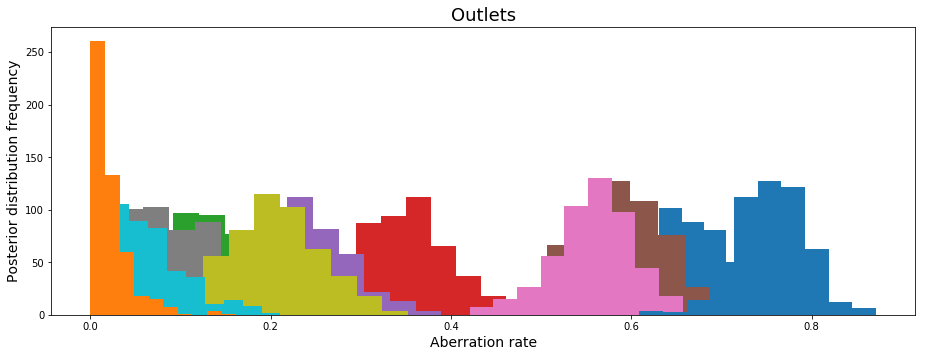

In [10]:
util.printEstimates(logistigateDict)
util.plotPostSamples(logistigateDict)

Note that the true SFP rates for the importers and outlets of this example are broadly contained within the intervals and posterior distributions presented.
Recall that we used 4,000 Tracked tests, and a relatively powerful diagnostic tool with $90\%$ sensitivity and $99\%$ specificity.
The next examples illustrate possible effects of having less robust testing paradigms.

#### Effect of fewer samples
To observe the effect of fewer samples, we will use a 1,000-sample version of the original 4,000-sample data set, contained in `example1bTestData.csv` as part of the `logistigate` package.
Follow the same steps as outlined above, and generate new posterior samples.

************************************************************************************************************************
ESTIMATE DICTIONARY VALUES
************************************************************************************************************************
Importer Name    Max. Lklhd. Est.    99% Lower    95% Lower    90% Lower    90% Upper    95% Upper    99% Upper
---------------  ------------------  -----------  -----------  -----------  -----------  -----------  -----------
Importer_1       32.2%               21.8%        24.1%        25.3%        39.9%        41.5%        44.6%
Importer_2       28.5%               19.6%        21.5%        22.6%        35.3%        36.7%        39.4%
Importer_3       16.5%               8.6%         10.1%        10.9%        24.0%        25.7%        29.2%
************************************************************************************************************************
************************************************************

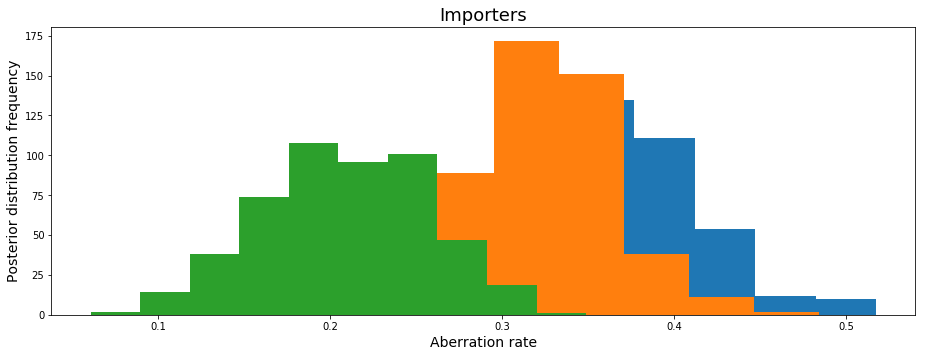

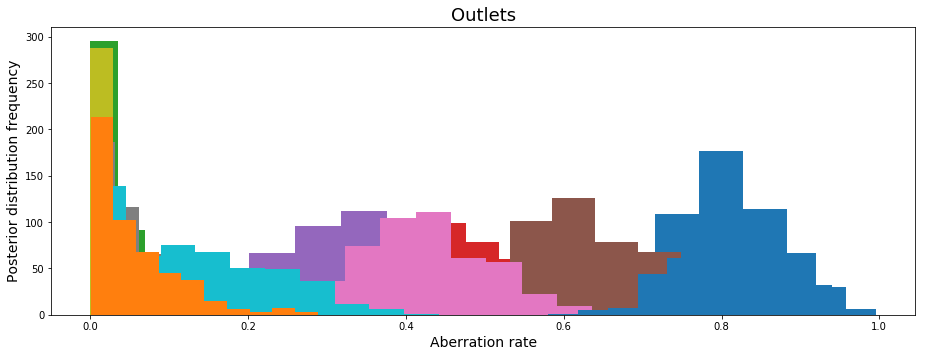

In [12]:
csv1bPath = pkg_resources.resource_filename('logistigate','data/example1bTestData.csv')
dataTblDict = util.TestResultsFileToTable(csv1bPath)
dataTblDict.update({'diagSens':0.90, 'diagSpec':0.99, 'numPostSamples':1000, 'prior':methods.prior_normal()})
logistigateDict = lg.runLogistigate(dataTblDict)
util.printEstimates(logistigateDict)
util.plotPostSamples(logistigateDict)

As should be anticipated, fewer samples translates to wider confidence intervals and posterior distributions.

#### Effect of diagnostic capacity
Next, we inspect the effect of reduced diagnostic capacity.
We suppose that we collected testing data from a supply chain with identical SFP rates and sourcing probabilities; however, our diagnostic tool in this case exhibits $70\%$ sensitivity and $90\%$ specificity.
We also revert to 4,000 data samples.
`example1cTestData.csv` contains data generated under this paradigm.

************************************************************************************************************************
ESTIMATE DICTIONARY VALUES
************************************************************************************************************************
Importer Name    Max. Lklhd. Est.    99% Lower    95% Lower    90% Lower    90% Upper    95% Upper    99% Upper
---------------  ------------------  -----------  -----------  -----------  -----------  -----------  -----------
Importer_1       39.4%               31.0%        32.9%        33.9%        45.1%        46.2%        48.4%
Importer_2       30.1%               22.6%        24.3%        25.2%        35.6%        36.7%        38.9%
Importer_3       8.9%                3.7%         4.6%         5.1%         15.1%        16.6%        20.0%
************************************************************************************************************************
************************************************************

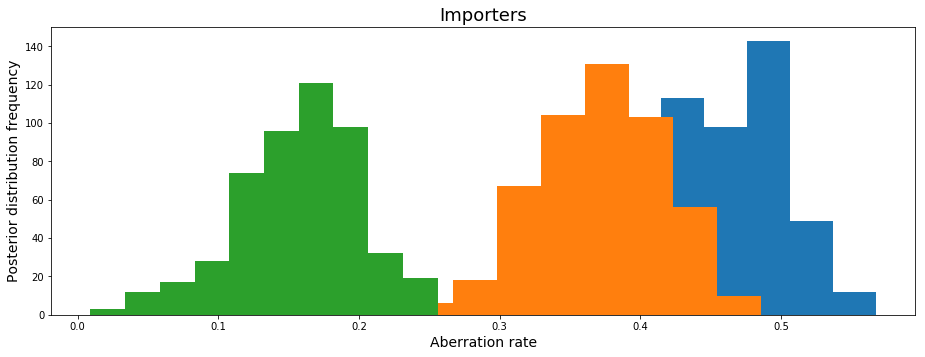

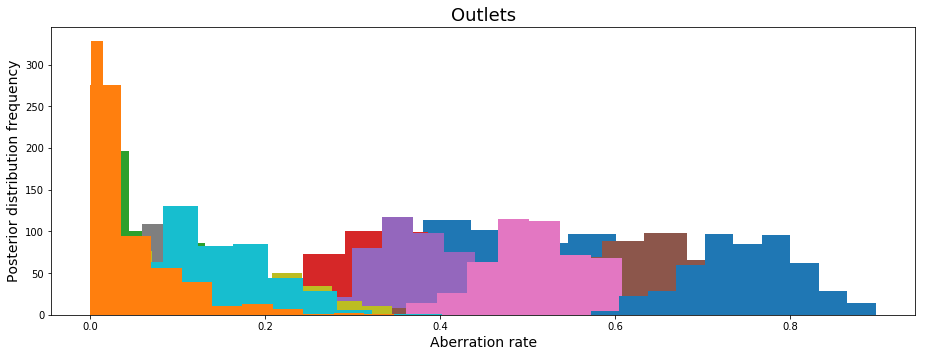

In [13]:
csv1cPath = pkg_resources.resource_filename('logistigate','data/example1cTestData.csv')
dataTblDict = util.TestResultsFileToTable(csv1cPath)
dataTblDict.update({'diagSens':0.70, 'diagSpec':0.90, 'numPostSamples':1000, 'prior':methods.prior_normal()})
logistigateDict = lg.runLogistigate(dataTblDict)
util.printEstimates(logistigateDict)
util.plotPostSamples(logistigateDict)

Again, as anticipated, reduced diagnostic capacity results in wider confidence intervals and posterior distributions.

#### Effect of prior choice
We next look at the effect of different priors on SFP rates.
Instead of using a Normal distribution, we use a Laplace distribution with the same mean and variance.

************************************************************************************************************************
ESTIMATE DICTIONARY VALUES
************************************************************************************************************************
Importer Name    Max. Lklhd. Est.    99% Lower    95% Lower    90% Lower    90% Upper    95% Upper    99% Upper
---------------  ------------------  -----------  -----------  -----------  -----------  -----------  -----------
Importer_1       36.1%               30.6%        31.9%        32.6%        39.9%        40.6%        42.0%
Importer_2       22.7%               17.5%        18.7%        19.3%        26.5%        27.3%        28.9%
Importer_3       12.3%               8.1%         9.0%         9.4%         15.8%        16.6%        18.2%
************************************************************************************************************************
************************************************************

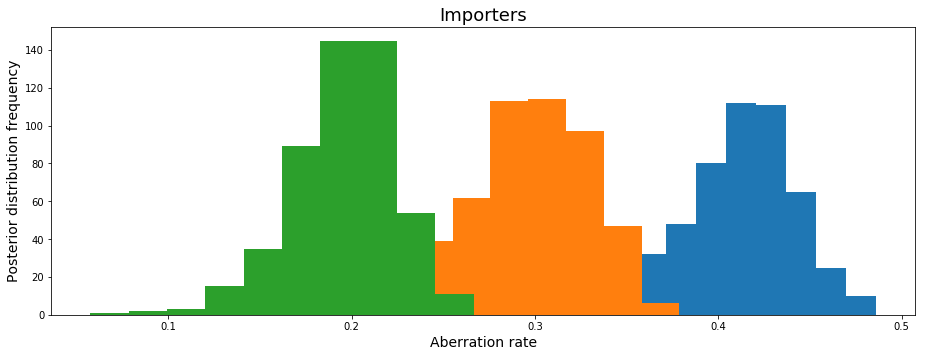

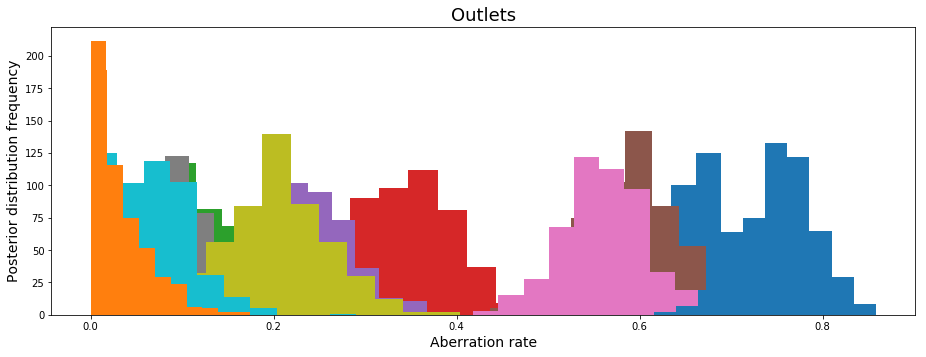

In [14]:
csv1Path = pkg_resources.resource_filename('logistigate','data/example1TestData.csv')
dataTblDict = util.TestResultsFileToTable(csv1Path)
dataTblDict.update({'diagSens':0.90, 'diagSpec':0.99, 'numPostSamples':1000, 'prior':methods.prior_laplace()})
logistigateDict = lg.runLogistigate(dataTblDict)
util.printEstimates(logistigateDict)
util.plotPostSamples(logistigateDict)

Although modest, we do observe an effect on the posterior distribution under a different prior choice.

### The Untracked setting
We next consider a supply chain with the same underlying SFP rates and sourcing probabilities, but in an Untracked setting.
The sourcing-probability matrix for outlets and importers is known. The first ten test data rows now appear as follows:

| Outlet Name | Test Result |
| --- | --- |
| Outlet_03 | 	1 |
| Outlet_09 | 	0 |
| Outlet_12 | 	1 |
| Outlet_01 | 	1 |
| Outlet_05 | 	0 |
| Outlet_09 | 	1 |
| Outlet_01 | 1 |
| Outlet_03 | 	0 |
| Outlet_09 | 	0 |
| Outlet_08 |   1 |


Testing data with only two columns will be interpreted as Untracked data, and `TestResultsFileToTable()` will require a second CSV path denoting the sourcing-probability matrix:

In [18]:
csv1Path = pkg_resources.resource_filename('logistigate','data/example2TestData.csv')
csv2Path = pkg_resources.resource_filename('logistigate','data/example1TransitionMatrix.csv')
dataTblDict = util.TestResultsFileToTable(csv1Path, csv2Path)
dataTblDict.update({'diagSens':0.90, 'diagSpec':0.99, 'numPostSamples':500, 'prior':methods.prior_normal()})
print(dataTblDict['type'])
print(dataTblDict['transMat'])

Untracked
[[0.69 0.22 0.09]
 [0.13 0.32 0.55]
 [0.39 0.51 0.1 ]
 [0.01 0.92 0.07]
 [0.28 0.22 0.5 ]
 [0.84 0.04 0.12]
 [0.11 0.6  0.29]
 [0.43 0.25 0.32]
 [0.11 0.65 0.24]
 [0.6  0.05 0.35]
 [0.05 0.15 0.8 ]
 [0.4  0.15 0.45]]


Note the `'transMat'` entry of the data dictionary now contains a Python version of the sourcing-probability matrix.

We use `runLogistigate()` as before, and observe the effect of Untracked versus Tracked for our example supply chain.

************************************************************************************************************************
ESTIMATE DICTIONARY VALUES
************************************************************************************************************************
Importer Name    Max. Lklhd. Est.    99% Lower    95% Lower    90% Lower    90% Upper    95% Upper    99% Upper
---------------  ------------------  -----------  -----------  -----------  -----------  -----------  -----------
Importer_1       41.0%               33.6%        35.3%        36.2%        46.0%        47.0%        48.8%
Importer_2       40.2%               33.5%        35.0%        35.8%        44.7%        45.6%        47.3%
Importer_3       8.5%                3.2%         4.0%         4.5%         15.2%        16.9%        20.8%
************************************************************************************************************************
************************************************************

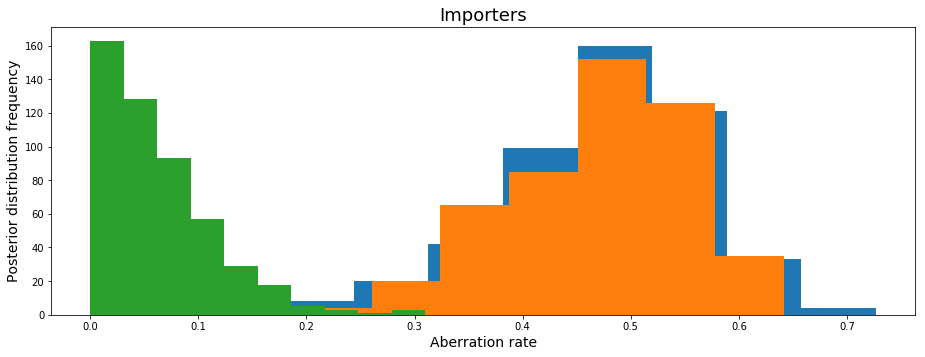

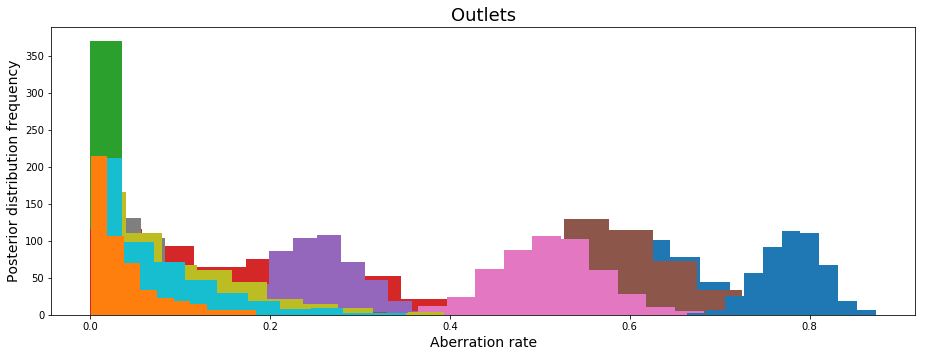

In [19]:
logistigateDict = lg.runLogistigate(dataTblDict)
util.printEstimates(logistigateDict)
util.plotPostSamples(logistigateDict)

As we should anticipate, the lack of precise knowledge regarding importer origin leads to wider confidence intervals and posterior distributions as compared with the Tracked setting.